In [2]:

library(GUniFrac)


In [9]:
#makarsa flashweave
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
# data file paths
original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
output_flash <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza'
neighbour='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/neighbours1.qza'
exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours'

heterogeneous=c()
sensitive=c()
max_k=c()
alpha=c()
f1=c()

#reading original reference data
data=read.csv(original_data, sep="\t", row.names=1)
#simulattion
sim.obj <- SimulateMSeq(
ref.otu.tab = data, nSam = length(colnames(data)), nOTU = length(rownames(data)),
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)

meta.dat <- data.frame(X = sim.obj$covariate, Z1 = sim.obj$confounder[, 1],
                       Z2 = sim.obj$confounder[, 2])
otu.tab.sim <- sim.obj$otu.tab.sim
actual=ifelse(sim.obj$diff.otu.ind, "DA", "NOT_DA")
tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
#otu data processing for qiime2 input
otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(data))])
colnames(otu)[1] <- "featureid"
rownames(otu) <- NULL

write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
#metadata processing for qiime2 input
colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

metad  <- cbind(rownames(meta.dat),meta.dat)
colnames(metad)[1] <- "sampleid"
rownames(metad) <- NULL
write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

# convert data into biom format
system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)


# Define the search space

param_space <- list(
    heterogeneous= c(TRUE, FALSE),
    sensitive= c(FALSE,TRUE),
    max_k= c(0, 1, 2, 3, 4),
    alpha= c(0.01, 0.02, 0.03, 0.04, 0.05)
    
)

# Number of random search iterations
n_iterations <- 1100

# Placeholder for storing results; here, I'm assuming you have a metric in mind
results <- list()

# Random search
for (i in 1:n_iterations) {
    
# deleting files 
# List of files you want to keep
files_to_keep <- c("meta_table.tsv", "meta_table1.tsv", "Running_qiime2_in_R.ipynb",
                  "qiime2_benchmark.ipynb", "otu_simpd.biom", "otu_table.txt",
                   "otu_table.txt1", "otu_table1.biom", "sim_meta.tsv")

# Get all files in the directory
all_files <- list.files()

# Determine which files to delete
files_to_delete <- setdiff(all_files, files_to_keep)

# Delete the files
file_deletion_results <- sapply(files_to_delete, function(file){
 if(file.info(file)$isdir){
    # If it's a directory, use unlink with recursive=TRUE
   unlink(file, recursive = TRUE)
  } else {
    # If it's a file, use file.remove
    file.remove(file)
  }
})    
    
    
  # Randomly sample hyperparameters
  params <- lapply(param_space, function(x) sample(x, size = 1))
   #import data into qiime 
  system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
  
  # Run FlashWeave with sampled parameters
    system(paste("qiime makarsa flashweave",
             "--i-table", output_qza,
             "--m-metadata-file",metadata,
             "--p-heterogeneous", params$heterogeneous,
             "--p-sensitive", params$sensitive,
             "--p-max-k", params$max_k,
             "--p-alpha", params$alpha,
             "--o-network", output_flash), intern=TRUE)                              
  
 
 
   system(paste("qiime makarsa list-neighbours",
                "--i-network",output_flash,
                "--p-feature-id", "covariate",
                "--p-radius",1,
                "--o-neighbours",neighbour), intern=TRUE)                 

  # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",neighbour,
             "--output-path",exported), intern=TRUE)                
  
  
  
  # Construct file path for metadata.tsv
  metadata_tsv <- paste0(exported, "/metadata.tsv")
  
  # Check if the file exists before reading
  if (!file.exists(metadata_tsv)) {
    cat("Expected metadata.tsv does not exist at path:", metadata_tsv, "\n")
    next
  }
  
  # Read the results
  neighbors <-read.csv(file = metadata_tsv, sep = '\t', row.names = 1)
  
  # take only necessary data
  neighbors=neighbors[-1,]
  row_names_df_to_remove=c("cofounder1","cofounder2")
  neighbors=neighbors[!(row.names(neighbors) %in% row_names_df_to_remove),]
  e=(rownames(otu.tab.sim)%in%rownames(neighbors))   
  pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
  df=cbind(pred,tr) 
  bet1=neighbors["Betweenness.Centrality"]
  bet=data.frame("Betweenness.Centrality" =rep(0,length(rownames(otu.tab.sim)[!e])),  row.names =rownames(otu.tab.sim)[!e] , stringsAsFactors = F)
  bet2=rbind(bet1,bet)
  out_df=cbind(df,bet2)
                   
    # neighbours=  neighbours[-1,] 
   # e=rownames(otu.tab.sim)%in%rownames(neighbours)   
    #pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
    #out_df=cbind(pred,tr) 
                   
# compute score for method measurement
# Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(out_df$truth == "DA", 1, 0)
  pred<- ifelse(out_df$pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)
  #score=precision+recall-fpr+f1_score
    score=(TP+TN)/(TP+TN+FP+FN)               
  
  # Store the result
  param_string <- paste(names(params), sapply(params, `[[`, 1), sep = ":", collapse = "_")
  results[[param_string]] <- f1_score

   heterogeneous=c(heterogeneous,params$heterogeneous)
   sensitive=c(sensitive,params$sensitive)
   max_k=c(max_k,params$max_k)
   alpha=c(alpha,params$alpha)
   f1=c(f1,f1_score)
                   
}
parameter_df<- data.frame("heterogeneous" =  heterogeneous,
                         "sensitive" = sensitive,
                         "max_k" = max_k,
                         "alpha" = alpha,
                         "f1_score"=f1,
                          stringsAsFactors = F)
                   
                   
                   
# Print the results
print(results)

# Choose the hyperparameters that yielded the best results
best_params <- names(which.max(unlist(results)))
cat("Best Parameters:", best_params, "\n")


Iteration 1: Log-likelihood value: -11619619.0649723

Iteration 2: Log-likelihood value: -11612587.7894874

Iteration 3: Log-likelihood value: -11603076.643171

Iteration 4: Log-likelihood value: -11595602.2195924

Iteration 5: Log-likelihood value: -11590231.1793153

Iteration 6: Log-likelihood value: -11586824.8767349

Iteration 7: Log-likelihood value: -11585043.9472959

Iteration 8: Log-likelihood value: -11584351.4437381

Iteration 9: Log-likelihood value: -11584174.3550922

Iteration 10: Log-likelihood value: -11584147.784376

Iteration 11: Log-likelihood value: -11584145.5829672

Iteration 12: Log-likelihood value: -11584145.4951697

Iteration 13: Log-likelihood value: -11584145.4924395

Iteration 14: Log-likelihood value: -11584145.4923573

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in 

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

character(0)

$`heterogeneous:1_sensitive:1_max_k:0_alpha:0.05`
[1] 0.4680851

$`heterogeneous:0_sensitive:1_max_k:3_alpha:0.03`
[1] 0.2898551

$`heterogeneous:0_sensitive:1_max_k:3_alpha:0.04`
[1] 0.2787879

$`heterogeneous:1_sensitive:1_max_k:3_alpha:0.04`
[1] 0.4620253

$`heterogeneous:1_sensitive:0_max_k:1_alpha:0.02`
[1] 0.32

$`heterogeneous:1_sensitive:0_max_k:0_alpha:0.02`
[1] 0.3947368

$`heterogeneous:0_sensitive:1_max_k:1_alpha:0.05`
[1] 0.2386588

$`heterogeneous:1_sensitive:0_max_k:4_alpha:0.05`
[1] 0.1456954

$`heterogeneous:1_sensitive:1_max_k:0_alpha:0.02`
[1] 0.4545455

$`heterogeneous:1_sensitive:1_max_k:1_alpha:0.05`
[1] 0.4680851

$`heterogeneous:1_sensitive:0_max_k:2_alpha:0.04`
[1] 0.1333333

$`heterogeneous:1_sensitive:1_max_k:3_alpha:0.03`
[1] 0.4635762

$`heterogeneous:1_sensitive:1_max_k:1_alpha:0.03`
[1] 0.4635762

$`heterogeneous:0_sensitive:0_max_k:4_alpha:0.05`
[1] 0.1025641

$`heterogeneous:0_sensitive:1_max_k:2_alpha:0.03`
[1] 0.2926829

$`heterogeneous:1_sensitive:1_

In [7]:
#Best Parameters: heterogeneous:1_sensitive:1_max_k:0_alpha:0.05 
#Best Parameters: heterogeneous:1_sensitive:1_max_k:0_alpha:0.03 
#Best Parameters: heterogeneous:1_sensitive:1_max_k:4_alpha:0.05 
#Best Parameters: heterogeneous:0_sensitive:1_max_k:0_alpha:0.05 
#Best Parameters: heterogeneous:0_sensitive:1_max_k:0_alpha:0.05 
#Best Parameters: heterogeneous:0_sensitive:0_max_k:3_alpha:0.01 
#Best Parameters: heterogeneous:1_sensitive:1_max_k:0_alpha:0.05
#Best Parameters: heterogeneous:1_sensitive:1_max_k:0_alpha:0.05 
#Best Parameters: heterogeneous:1_sensitive:1_max_k:1_alpha:0.04
#Best Parameters: heterogeneous:1_sensitive:1_max_k:0_alpha:0.03

In [62]:
data=read.table(original_data, sep="\t", header=1, row.names=1)
#read.table(file, sep = '\t', header=TRUE, row.names=1)

In [64]:
#data

In [77]:
#makarsa flashweave neighbour
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
# data file paths
original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
american_gut<- "~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/american_gut_10317/american_gut_otu_table.tsv"
#IDB dataframe
simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
output_flash <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza'
neighbr='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/neighbours1.qza'
exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours'


#reading original reference data
data=read.table(original_data, sep="\t",header=1, row.names=1)
#simulattion
sim.obj <- SimulateMSeq(
ref.otu.tab = data, nSam = length(colnames(data)), nOTU = length(rownames(data)),
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)

meta.dat <- data.frame(X = sim.obj$covariate, Z1 = sim.obj$confounder[, 1],
                       Z2 = sim.obj$confounder[, 2])
otu.tab.sim <- sim.obj$otu.tab.sim
actual=ifelse(sim.obj$diff.otu.ind, "DA", "NOT_DA")
tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
#otu data processing for qiime2 input
otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(data))])
colnames(otu)[1] <- "featureid"
rownames(otu) <- NULL

write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
#metadata processing for qiime2 input
colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

metad  <- cbind(rownames(meta.dat),meta.dat)
colnames(metad)[1] <- "sampleid"
rownames(metad) <- NULL
write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

# convert data into biom format
system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)


#import data into qiime 
  system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
  
  # Run FlashWeave with sampled parameters
    system(paste("qiime makarsa flashweave",
             "--i-table", output_qza,
             "--m-metadata-file",metadata,
             "--p-heterogeneous", TRUE,
             "--p-sensitive", TRUE,
             "--p-max-k", 0,
             "--p-alpha", 0.04,
             "--o-network", output_flash), intern=TRUE)

Iteration 1: Log-likelihood value: -11619619.0649723

Iteration 2: Log-likelihood value: -11612587.7894874

Iteration 3: Log-likelihood value: -11603076.643171

Iteration 4: Log-likelihood value: -11595602.2195924

Iteration 5: Log-likelihood value: -11590231.1793153

Iteration 6: Log-likelihood value: -11586824.8767349

Iteration 7: Log-likelihood value: -11585043.9472959

Iteration 8: Log-likelihood value: -11584351.4437381

Iteration 9: Log-likelihood value: -11584174.3550922

Iteration 10: Log-likelihood value: -11584147.784376

Iteration 11: Log-likelihood value: -11584145.5829672

Iteration 12: Log-likelihood value: -11584145.4951697

Iteration 13: Log-likelihood value: -11584145.4924395

Iteration 14: Log-likelihood value: -11584145.4923573

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in 

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

character(0)

[1] "Imported /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom as BIOMV210Format to /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza"

[1] "Saved Network to: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza"

In [83]:
# Run FlashWeave with sampled parameters
    system(paste("qiime makarsa flashweave",
             "--i-table", output_qza,
             "--m-metadata-file",metadata,
             "--p-heterogeneous", TRUE,
             "--p-sensitive", TRUE,
             "--p-max-k", 0,
             "--p-alpha", 0.04,
             "--o-network", output_flash), intern=TRUE)

[1] "Saved Network to: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza"

In [84]:

# Define the search space

param_space <- list(
    radius= c(1, 2, 3, 4,5,6)
)

# Number of random search iterations
n_iterations <- 20



# Placeholder for storing results; here, I'm assuming you have a metric in mind
results <- list()

# Random search
for (i in 1:n_iterations) {
      
  # Randomly sample hyperparameters
  params <- lapply(param_space, function(x) sample(x, size = 1))
                              
   system(paste("qiime makarsa list-neighbours",
                "--i-network",output_flash,
                "--p-feature-id", "covariate",
                "--p-radius",params$radius,
                "--o-neighbours",neighbr), intern=TRUE)                 

  # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",neighbr,
             "--output-path",exported), intern=TRUE)                
  
  
  
  # Construct file path for metadata.tsv
  metadata_tsv <- paste0(exported, "/metadata.tsv")
  
  # Check if the file exists before reading
  if (!file.exists(metadata_tsv)) {
    cat("Expected metadata.tsv does not exist at path:", metadata_tsv, "\n")
    next
  }
  
  # Read the results
  neighbors <-read.csv(file = metadata_tsv, sep = '\t', row.names = 1)
  
  # take only necessary data
  neighbors=neighbors[-1,]
  row_names_df_to_remove=c("cofounder1","cofounder2")
  neighbors=neighbors[!(row.names(neighbors) %in% row_names_df_to_remove),]
  e=(rownames(otu.tab.sim)%in%rownames(neighbors))   
  pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
  df=cbind(pred,tr) 
  bet1=neighbors["Betweenness.Centrality"]
  bet=data.frame("Betweenness.Centrality" =rep(0,length(rownames(otu.tab.sim)[!e])),  row.names =rownames(otu.tab.sim)[!e] , stringsAsFactors = F)
  bet2=rbind(bet1,bet)
  out_df=cbind(df,bet2)
                   
    # neighbours=  neighbours[-1,] 
   # e=rownames(otu.tab.sim)%in%rownames(neighbours)   
    #pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
    #out_df=cbind(pred,tr) 
                   
# compute score for method measurement
# Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(out_df$truth == "DA", 1, 0)
  pred<- ifelse(out_df$pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)
  #score=precision+recall-fpr+f1_score
    #score=(TP+TN)/(TP+TN+FP+FN)               
  
  # Store the result
  param_string <- paste(names(params), sapply(params, `[[`, 1), sep = ":", collapse = "_")
  results[[param_string]] <- f1_score

 }  
                   
                   
# Print the results
print(results)

# Choose the hyperparameters that yielded the best results
best_params <- names(which.max(unlist(results)))
cat("Best Parameters:", best_params, "\n")


$`radius:2`
[1] 0.4646465

$`radius:3`
[1] 0.4920128

$`radius:5`
[1] 0.4888889

$`radius:4`
[1] 0.4888889

$`radius:6`
[1] 0.4888889

$`radius:1`
[1] 0.2666667

Best Parameters: radius:3 


In [ ]:
#Best Parameters: radius:2 0.4496644
#Best Parameters: radius:2 0.4496644
#Best Parameters: radius:2 0.4496644
#Best Parameters: radius:2 0.4496644
#Best Parameters: radius:4 0.3622351,3 times
#Best Parameters: radius:3 0.4920128,4 times

In [50]:
exported_net<- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_net'

In [79]:
system(paste("qiime tools export", 
              "--input-path",output_flash,
             "--output-path",exported_net), intern=TRUE)

[1] "Exported /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/flashnet1.qza as NetworkDirectoryFormat to directory /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_net"

In [70]:
graph <- read.graph(exported, format = "graphml")

ERROR: Error in read.graph(exported, format = "graphml"): could not find function "read.graph"


In [38]:
exported ='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/network.graphml'

In [39]:
# Load the igraph library
library(igraph)

# Specify the path to your GraphML file
graphml_file <- "path/to/your/graph.graphml"

# Read the GraphML file
graph <- read.graph(exported)

# Now, you have your graph loaded in the 'graph' variable


ERROR: Error in read.graph.edgelist(file, ...): At core/io/edgelist.c:97 : parsing edgelist file failed, Parse error


In [ ]:
#f1_score
#$`radius:3` 0.4768212
#Best Parameters: radius:2 
#$`radius:5`
#[1] 0.4422442
#Best Parameters: radius:3, 0.4774194

#accuracy
#Best Parameters: radius:1 ,0.8928
#Best Parameters: radius:1 , 0.8928
#Best Parameters: radius:1, 0.8928
#Best Parameters: radius:1 , 0.8824


#% .2%
#Best Parameters: radius:5, 0.8536
#Best Parameters: radius:4, 0.8448


In [41]:
#SpiecEasi
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
# data file paths
original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
output_spiec <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/spiecnet1.qza'
neighbours='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/neighbours1.qza'
exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours'

#reading original reference data
data=read.csv(original_data, sep="\t", row.names=1)
#simulattion
sim.obj <- SimulateMSeq(
ref.otu.tab = data, nSam = 200, nOTU =300,
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)

meta.dat <- data.frame(X = sim.obj$covariate, Z1 = sim.obj$confounder[, 1],
                       Z2 = sim.obj$confounder[, 2])
otu.tab.sim <- sim.obj$otu.tab.sim
actual=ifelse(sim.obj$diff.otu.ind, "DA", "NOT_DA")
tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
#otu data processing for qiime2 input
otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:200])
colnames(otu)[1] <- "featureid"
rownames(otu) <- NULL

write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
#metadata processing for qiime2 input
colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

metad  <- cbind(rownames(meta.dat),meta.dat)
colnames(metad)[1] <- "sampleid"
rownames(metad) <- NULL
write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

# convert data into biom format
system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)


# Define the search space

param_space <- list(
  method = c('mb'),
  lambdaminratio = seq(0.01, 0.05, by=0.01),
  nlambda = seq(50, 100, by=10),
  #ncores = c(12),
  ncores = c(15,16),
  #thresh = c(0.01),
  thresh = seq(0.01, 0.1, by=0.01),
  #subsampleratio = c(0.1),
  subsampleratio = seq(0.1, 1, by=0.1),
  #seed = 400,
  seed = sample(1:1000, 5),
  #lambdamin = c(0.01),
   lambdamin = seq(0.01, 0.1, by=0.01),
     lambdamax = seq(0.1, 1, by=0.1)
 # lambdamax = c(0.1)
        
)

# Number of random search iterations
n_iterations <- 10

# Placeholder for storing results; here, I'm assuming you have a metric in mind
results <- list()

# Random search
for (i in 1:n_iterations) {
    
    # deleting files 
# List of files you want to keep
files_to_keep <- c("meta_table.tsv", "meta_table1.tsv", "Running_qiime2_in_R.ipynb",
                   "qiime2_benchmark.ipynb", "otu_simpd.biom", "otu_table.txt",
                   "otu_table.txt1", "otu_table1.biom", "sim_meta.tsv")

# Get all files in the directory
all_files <- list.files()

# Determine which files to delete
files_to_delete <- setdiff(all_files, files_to_keep)

# Delete the files
file_deletion_results <- sapply(files_to_delete, function(file){
  if(file.info(file)$isdir){
    # If it's a directory, use unlink with recursive=TRUE
    unlink(file, recursive = TRUE)
  } else {
    # If it's a file, use file.remove
    file.remove(file)
  }
})
    
  # Randomly sample hyperparameters
  params <- lapply(param_space, function(x) sample(x, size = 1))
  
  #import data into qiime
   system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)                

  # Run spieceasi with sampled parameters
   system(paste("qiime makarsa spiec-easi",
             "--i-table", output_qza,
             "--m-metadata-file",metadata,
             "--p-method", params$method,
             "--p-lambda-min-ratio", params$lambdaminratio,
             "--p-nlambda", params$nlambda,
             "--p-ncores", params$ncores,
             "--p-thresh", params$thresh,
             "--p-subsample-ratio", params$subsampleratio,   
             "--p-seed", params$seed,   
             "--p-lambda-min", params$lambdamin,  
             "--p-lambda-max", params$lambdamax,
             "--o-network", output_spiec))                
 
   system(paste("qiime makarsa list-neighbours",
                "--i-network",output_spiec,
                "--o-neighbours",neighbours,
                "--p-feature-id", "covariate"))                 

  # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",neighbours,
             "--output-path",exported))                
  
  # Construct file path for metadata.tsv
  metadata_tsv <- paste0(exported, "/metadata.tsv")
  
  # Check if the file exists before reading
  if (!file.exists(metadata_tsv)) {
    cat("Expected metadata.tsv does not exist at path:", metadata_tsv, "\n")
    next
  }
  
  # Read the q-value results
  neighbour <-read.csv(file = metadata_tsv, sep = '\t', row.names = 1)
  
  
  # take only necessary data
     neighbours=  neighbours[-1,] 
     e=(rownames(otu.tab.sim)%in%rownames(neighbor))   
     pred=data.frame("pred" =ifelse(e, "DA", "NOT_DA") , row.names =rownames(otu.tab.sim) , stringsAsFactors = F)
     out_df=cbind(pred,tr) 
                   
# compute score for method measurement
# Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(out_df$truth == "DA", 1, 0)
  pred<- ifelse(out_df$pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)
  #score=precision+recall-fpr+f1_score
    score=(TP+TN)/(TP+TN+FP+FN)               
  
  # Store the result
  param_string <- paste(names(params), sapply(params, `[[`, 1), sep = ":", collapse = "_")
  results[[param_string]] <- score
}

# Print the results
print(results)

# Choose the hyperparameters that yielded the best results
best_params <- names(which.max(unlist(results)))
cat("Best Parameters:", best_params, "\n")


Iteration 1: Log-likelihood value: -11619619.0649723

Iteration 2: Log-likelihood value: -11612587.7894874

Iteration 3: Log-likelihood value: -11603076.643171

Iteration 4: Log-likelihood value: -11595602.2195924

Iteration 5: Log-likelihood value: -11590231.1793153

Iteration 6: Log-likelihood value: -11586824.8767349

Iteration 7: Log-likelihood value: -11585043.9472959

Iteration 8: Log-likelihood value: -11584351.4437381

Iteration 9: Log-likelihood value: -11584174.3550922

Iteration 10: Log-likelihood value: -11584147.784376

Iteration 11: Log-likelihood value: -11584145.5829672

Iteration 12: Log-likelihood value: -11584145.4951697

Iteration 13: Log-likelihood value: -11584145.4924395

Iteration 14: Log-likelihood value: -11584145.4923573

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in 

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

character(0)

Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_neighbours/metadata.tsv 
Expected metadata.tsv does not exist at path: /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/expor

In [194]:
#Best Parameters: method:mb_lambda.min.ratio:0.05_nlambda:30_ncores:12_thresh:0.02_subsample.ratio:1_seed:470_lambda.min:0.06_lambda.max:1 

In [13]:
#ANCOMBC
library(pROC)
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
# data file paths
original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
ancomoutput <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/ancombc.qza'
exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_ancompd'

#reading original reference data
data=read.csv(original_data, sep="\t", row.names=1)
#simulattion
sim.obj <- SimulateMSeq(
ref.otu.tab = data, nSam = length(colnames(data)), nOTU = length(rownames(data)),
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)

meta.dat <- data.frame(X = sim.obj$covariate, Z1 = sim.obj$confounder[, 1],
                       Z2 = sim.obj$confounder[, 2])
otu.tab.sim <- sim.obj$otu.tab.sim
actual=ifelse(sim.obj$diff.otu.ind, "DA", "NOT_DA")
tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
#otu data processing for qiime2 input
otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(data))])
colnames(otu)[1] <- "featureid"
rownames(otu) <- NULL

write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
#metadata processing for qiime2 input
colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

metad  <- cbind(rownames(meta.dat),meta.dat)
colnames(metad)[1] <- "sampleid"
rownames(metad) <- NULL
write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

# convert data into biom format
system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)

# initialized parameter vector
adj_method=c()
zerocut=c()
libcut=c()
neglib=c()
tolerance=c()
maxit=c()
conserv=c()
alpa=c()
glob=c()
accuracy=c()
f1=c()
# Define the search space
param_space <- list(
  p_adj_method = c("holm", "hochberg", "hommel", "bonferroni", "BH", "BY", "fdr"),
  zero_cut = seq(0.1, 1, by=0.1),
  lib_cut = seq(0, 100, by=10),
  tol = c(1e-03, 1e-04, 1e-05, 1e-06),
  max_iter = seq(50, 200, by=25),
  conserve = c(TRUE, FALSE),
  alpha = seq(0.01, 0.1, by=0.01)
  #global = c(TRUE, FALSE)
)

# Number of random search iterations
n_iterations <- 100

# Placeholder for storing results; 
results <- list()

# Random search
for (i in 1:n_iterations) {

# deleting files 
# List of files you want to keep
files_to_keep <- c("meta_table.tsv", "meta_table1.tsv", "Running_qiime2_in_R.ipynb",
                   "qiime2_benchmark.ipynb", "otu_simpd.biom", "otu_table.txt",
                   "otu_table.txt1", "otu_table1.biom", "sim_meta.tsv")

# Get all files in the directory
all_files <- list.files()

# Determine which files to delete
files_to_delete <- setdiff(all_files, files_to_keep)

# Delete the files
file_deletion_results <- sapply(files_to_delete, function(file){
  if(file.info(file)$isdir){
    # If it's a directory, use unlink with recursive=TRUE
    unlink(file, recursive = TRUE)
  } else {
    # If it's a file, use file.remove
    file.remove(file)
  }
})
    

  # Randomly sample hyperparameters
  params <- lapply(param_space, function(x) sample(x, size = 1))
  
   #import data into qiime2                
  system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
                   
  # Run ANCOM-BC with sampled parameters
   system(paste("qiime composition ancombc",
             "--i-table",output_qza,
             "--m-metadata-file", metadata,
             "--p-formula", "covariate",
             # "--p-p-adj-method", params$p_adj_method,
            # "--p-zero-cut", params$zero_cut,
              "--p-lib-cut", params$lib_cut,
            #"--p-struc_zero", TRUE,             #as OTU IS USALLY sparce ,it is recommended to choose neg-lib=false
            "--p-neg-lb", FALSE,                 #neg-lib has no funtionality if we choose struc-zero =false
             "--p-tol", params$tol,
             "--p-max-iter", params$max_iter,
             "--p-conserve", params$conserve,
             "--p-alpha", params$alpha,
            # "--p-global", params$global,
             "--o-differentials", ancomoutput))                
  
  
  
  # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",ancomoutput,
             "--output-path",exported))                
  
  # Construct file path for q_val_slice.csv
  q_val_csv <- paste0(exported, "/q_val_slice.csv")
  
  # Check if the file exists before reading
  if (!file.exists(q_val_csv)) {
    cat("Expected q_val_slice.csv does not exist at path:", q_val_csv, "\n")
    next
  }
  
  # Read the q-value results
  ancom_q_val <- read.csv(file = q_val_csv, sep = ',', row.names = 1)

  
  
  
  # take only necessary data
   ancom_q_val=data.frame("covariateunhealthy" = ancom_q_val$covariateunhealthy, row.names = rownames(ancom_q_val), stringsAsFactors = F)
  #construct output dataframe
    e=!(rownames(otu.tab.sim)%in%rownames(ancom_q_val))
    nq=rownames(otu.tab.sim)[e]
    nqv=data.frame("covariateunhealthy" = rep(NA, length(nq)), row.names = nq, stringsAsFactors = F)
    q_val_all=rbind(ancom_q_val,nqv)
    names(q_val_all)[names(q_val_all) == "covariateunhealthy"] <- "q_value"
    pred= ifelse(ancom_q_val < 0.05, "DA", "NOT_DA")
    pred=as.data.frame(pred)
    d=!(rownames(otu.tab.sim)%in%rownames(pred))
    npred=rownames(otu.tab.sim)[d]
    ND=data.frame("covariateunhealthy" = rep("NOT_DA", length(npred)), row.names = npred, stringsAsFactors = F)
    pr=rbind(pred,ND)
    out_df=cbind(pr,q_val_all,tr)
    names(out_df)[names(out_df) == "covariateunhealthy"] <- "pred"

# compute score for method measurement
# Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(out_df$truth == "DA", 1, 0)
  pred<- ifelse(out_df$pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)
  #score=precision+recall-fpr+f1_score
  score=(TP+TN)/(TP+TN+FP+FN)   
  

  # Store the result
  param_string <- paste(names(params), sapply(params, `[[`, 1), sep = ":", collapse = "_")
  results[[param_string]] <- f1_score
   
   adj_method=c(adj_method,params$p_adj_method)
   #zerocut=c(zerocut,)
   libcut=c(libcut,params$lib_cut)
   #neglib=c(neglib,params$neg_lb)
   tolerance=c(tolerance,params$tol)
   maxit=c(maxit,params$max_iter)
   conserv=c(conserv,params$conserve)
   alpa=c(alpa,params$alpha)
  # glob=c(glob,params$global)
   accuracy=c(accuracy,score) 
    f1=c(f1,f1_score)
                   
}
parameter_df<- data.frame("p-adj-method" =  adj_method,
                         "lib_cut" = libcut,
                         #"neg_lb" = neglib,
                         "tol" = tolerance,
                         "max_iter" = maxit,
                         "conserve" = conserv,
                         "alpa" = alpa,
                          "accuracy" = accuracy,
                          "f1_score"=f1,
                         stringsAsFactors = F)
# Print the results
 print(results)

# Choose the hyperparameters that yielded the best results
best_params <- names(which.max(unlist(results)))
cat("Best Parameters:", best_params, "\n")


Iteration 1: Log-likelihood value: -11619619.0649723

Iteration 2: Log-likelihood value: -11612587.7894874

Iteration 3: Log-likelihood value: -11603076.643171

Iteration 4: Log-likelihood value: -11595602.2195924

Iteration 5: Log-likelihood value: -11590231.1793153

Iteration 6: Log-likelihood value: -11586824.8767349

Iteration 7: Log-likelihood value: -11585043.9472959

Iteration 8: Log-likelihood value: -11584351.4437381

Iteration 9: Log-likelihood value: -11584174.3550922

Iteration 10: Log-likelihood value: -11584147.784376

Iteration 11: Log-likelihood value: -11584145.5829672

Iteration 12: Log-likelihood value: -11584145.4951697

Iteration 13: Log-likelihood value: -11584145.4924395

Iteration 14: Log-likelihood value: -11584145.4923573

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in 

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

character(0)

$`p_adj_method:BY_zero_cut:0.5_lib_cut:50_tol:1e-06_max_iter:200_conserve:FALSE_alpha:0.07`
[1] 0.1398601

$`p_adj_method:hommel_zero_cut:0.4_lib_cut:70_tol:1e-06_max_iter:75_conserve:TRUE_alpha:0.07`
[1] 0.1014493

$`p_adj_method:holm_zero_cut:0.3_lib_cut:60_tol:1e-04_max_iter:50_conserve:TRUE_alpha:0.03`
[1] 0.1014493

$`p_adj_method:hochberg_zero_cut:0.7_lib_cut:40_tol:1e-06_max_iter:175_conserve:TRUE_alpha:0.05`
[1] 0.1014493

$`p_adj_method:hommel_zero_cut:0.3_lib_cut:20_tol:1e-05_max_iter:100_conserve:FALSE_alpha:0.06`
[1] 0.1398601

$`p_adj_method:hommel_zero_cut:0.3_lib_cut:60_tol:0.001_max_iter:125_conserve:TRUE_alpha:0.02`
[1] 0.1014493

$`p_adj_method:holm_zero_cut:0.1_lib_cut:40_tol:0.001_max_iter:100_conserve:FALSE_alpha:0.04`
[1] 0.1398601

$`p_adj_method:hommel_zero_cut:1_lib_cut:60_tol:1e-06_max_iter:100_conserve:FALSE_alpha:0.1`
[1] 0.1398601

$`p_adj_method:holm_zero_cut:0.5_lib_cut:90_tol:1e-05_max_iter:150_conserve:TRUE_alpha:0.02`
[1] 0.1014493

$`p_adj_method:holm

Best Parameters: p_adj_method:BY_zero_cut:0.5_lib_cut:50_tol:1e-06_max_iter:200_conserve:FALSE_alpha:0.07 


In [ ]:
#Best Parameters: p_adj_method:BY_zero_cut:0.7_lib_cut:100_struc_zero:FALSE_neg_lb:FALSE_tol:1e-05_max_iter:50_conserve:FALSE_alpha:0.04_global:TRUE 
#Best Parameters: p_adj_method:BH_zero_cut:0.5_lib_cut:30_struc_zero:FALSE_neg_lb:TRUE_tol:0.001_max_iter:100_conserve:TRUE_alpha:0.03_global:TRUE
#Best Parameters: p_adj_method:fdr_zero_cut:0.8_lib_cut:70_struc_zero:FALSE_neg_lb:FALSE_tol:1e-04_max_iter:125_conserve:TRUE_alpha:0.1_global:FALSE 
#Best Parameters: p_adj_method:fdr_zero_cut:0.7_lib_cut:50_struc_zero:TRUE_neg_lb:TRUE_tol:1e-04_max_iter:50_conserve:FALSE_alpha:0.07_global:FALSE 
#Best Parameters: p_adj_method:BH_zero_cut:1_lib_cut:30_struc_zero:TRUE_neg_lb:FALSE_tol:1e-05_max_iter:50_conserve:FALSE_alpha:0.09_global:TRUE 
#Best Parameters: p_adj_method:holm_zero_cut:0.2_lib_cut:70_struc_zero:FALSE_neg_lb:FALSE_tol:1e-06_max_iter:150_conserve:TRUE_alpha:0.06_global:TRUE
#Best Parameters: p_adj_method:holm_zero_cut:0.4_lib_cut:10_struc_zero:TRUE_neg_lb:TRUE_tol:1e-04_max_iter:125_conserve:TRUE_alpha:0.07_global:TRUE 
#Best Parameters: p_adj_method:bonferroni_zero_cut:0.3_lib_cut:50_struc_zero:FALSE_neg_lb:FALSE_tol:1e-04_max_iter:200_conserve:TRUE_alpha:0.05_global:TRUE 
#best Parameters: p_adj_method:BH_zero_cut:0.2_lib_cut:20_struc_zero:FALSE_neg_lb:FALSE_tol:1e-04_max_iter:75_conserve:FALSE_alpha:0.07_global:TRUE
#Best Parameters: p_adj_method:BY_zero_cut:0.6_lib_cut:90_struc_zero:FALSE_neg_lb:TRUE_tol:0.001_max_iter:125_conserve:FALSE_alpha:0.07_global:FALSE 
#Best Parameters: p_adj_method:hochberg_zero_cut:0.8_lib_cut:10_struc_zero:FALSE_neg_lb:FALSE_tol:1e-05_max_iter:175_conserve:TRUE_alpha:0.1_global:TRUE 
#Best Parameters: p_adj_method:holm_zero_cut:0.7_lib_cut:70_struc_zero:FALSE_neg_lb:TRUE_tol:1e-05_max_iter:150_conserve:TRUE_alpha:0.07_global:TRUE 

#final
#Best Parameters: p_adj_method:BY_zero_cut:0.9_lib_cut:90_tol:0.001_max_iter:50_conserve:FALSE_alpha:0.08 
#Best Parameters: p_adj_method:BY_zero_cut:0.7_lib_cut:30_tol:1e-04_max_iter:50_conserve:FALSE_alpha:0.04
#Best Parameters: p_adj_method:BH_zero_cut:0.4_lib_cut:0_tol:1e-05_max_iter:125_conserve:FALSE_alpha:0.01 
#Best Parameters: p_adj_method:BH_zero_cut:0.4_lib_cut:60_tol:0.001_max_iter:200_conserve:FALSE_alpha:0.07 
#Best Parameters: p_adj_method:BY_zero_cut:0.5_lib_cut:50_tol:1e-06_max_iter:200_conserve:FALSE_alpha:0.07

In [2]:
library(pROC)

In [18]:
#ANCOMBC default parameter
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")
# data file paths
original_data<-"~/from_pendrive/PhD/DAA_benchmark_study/qiime_ancombc/data/PD_10483/otu_pd_qiime.tsv"
simulated_data<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.txt"
biom_file <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom'
output_qza <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza'
metadata<-"/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/meta_table1.tsv"
ancomoutput <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/ancombc.qza'
exported <- '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/exported_ancompd'

#reading original reference data
data=read.csv(original_data, sep="\t", row.names=1)
#simulattion
sim.obj <- SimulateMSeq(
ref.otu.tab = data, nSam = length(colnames(data)), nOTU = length(rownames(data)),
# True signal setting
diff.otu.pct = 0.1, diff.otu.direct = c("unbalanced"), 
diff.otu.mode = c("abundant"),
covariate.type = c("binary"), grp.ratio = 1,
covariate.eff.mean = 1.0, covariate.eff.sd = 0,
# Confounder signal setting
confounder.type = c("both"), conf.cov.cor = 0.6,
conf.diff.otu.pct = 0.1, conf.nondiff.otu.pct = 0.1,
confounder.eff.mean = 1.0, confounder.eff.sd = 0,
# Depth setting
depth.mu = 10000, depth.theta = 5, depth.conf.factor = 0
)

meta.dat <- data.frame(X = sim.obj$covariate, Z1 = sim.obj$confounder[, 1],
                       Z2 = sim.obj$confounder[, 2])
otu.tab.sim <- sim.obj$otu.tab.sim
actual=ifelse(sim.obj$diff.otu.ind, "DA", "NOT_DA")
tr=data.frame("truth" = actual, row.names = rownames(otu.tab.sim), stringsAsFactors = F)
meta.dat$X=ifelse(meta.dat$X, "healthy","unhealthy")
#otu data processing for qiime2 input
otu <- cbind(rownames(otu.tab.sim), otu.tab.sim[,2:length(colnames(data))])
colnames(otu)[1] <- "featureid"
rownames(otu) <- NULL

write.table(otu, simulated_data, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)
#metadata processing for qiime2 input
colnames(meta.dat)=c("covariate", "cofounder1","cofounder2")

metad  <- cbind(rownames(meta.dat),meta.dat)
colnames(metad)[1] <- "sampleid"
rownames(metad) <- NULL
write.table(metad, metadata, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

# convert data into biom format
system(paste("biom convert",
                 "-i",simulated_data ,
                 "-o", biom_file ,
                 "--table-type=\"OTU table\"",
                 "--to-hdf5"), intern=TRUE)

  
   #import data into qiime2                
  system(paste("qiime tools import",
             "--input-path", biom_file,
             "--type 'FeatureTable[Frequency]'",
             "--input-format BIOMV210Format",
             "--output-path", output_qza), intern=TRUE)
                   
  # Run ANCOM-BC with sampled parameters
   system(paste("qiime composition ancombc",
             "--i-table",output_qza,
             "--m-metadata-file", metadata,
             "--p-formula", "covariate",
             "--o-differentials", ancomoutput))                
  
  
  
  # Export the results from QIIME2
   system(paste("qiime tools export", 
              "--input-path",ancomoutput,
             "--output-path",exported))                
  
  # Construct file path for q_val_slice.csv
  q_val_csv <- paste0(exported, "/q_val_slice.csv")
  
  # Check if the file exists before reading
  if (!file.exists(q_val_csv)) {
    cat("Expected q_val_slice.csv does not exist at path:", q_val_csv, "\n")
    next
  }
  
  # Read the q-value results
  ancom_q_val <- read.csv(file = q_val_csv, sep = ',', row.names = 1)

  
  
  
  # take only necessary data
   ancom_q_val=data.frame("covariateunhealthy" = ancom_q_val$covariateunhealthy, row.names = rownames(ancom_q_val), stringsAsFactors = F)
  #construct output dataframe
    e=!(rownames(otu.tab.sim)%in%rownames(ancom_q_val))
    nq=rownames(otu.tab.sim)[e]
    nqv=data.frame("covariateunhealthy" = rep(NA, length(nq)), row.names = nq, stringsAsFactors = F)
    q_val_all=rbind(ancom_q_val,nqv)
    names(q_val_all)[names(q_val_all) == "covariateunhealthy"] <- "q_value"
    pred= ifelse(ancom_q_val < 0.05, "DA", "NOT_DA")
    pred=as.data.frame(pred)
    d=!(rownames(otu.tab.sim)%in%rownames(pred))
    npred=rownames(otu.tab.sim)[d]
    ND=data.frame("covariateunhealthy" = rep("NOT_DA", length(npred)), row.names = npred, stringsAsFactors = F)
    pr=rbind(pred,ND)
    out_df=cbind(pr,q_val_all,tr)
    names(out_df)[names(out_df) == "covariateunhealthy"] <- "pred"

# compute score for method measurement
# Reassign the labels. The positive class is the one with the lowest number, i.e. "DA":
  truth<- ifelse(out_df$truth == "DA", 1, 0)
  pred<- ifelse(out_df$pred == "DA", 1, 0)

  # Compute the number of False Positive (FP), False Negative (FN), True Positive (TP), True Negative (TN):
  FP<- sum(truth==0 & pred==1)
  FN<- sum(truth==1 & pred==0)
  TP<- sum(truth==1 & pred==1)
  TN<- sum(truth==0 & pred==0)

  # Calculate Precision and Recall:
  if(TP==0 & FP==0){
    precision<- NA
  }else{
    precision<- TP/(TP+FP)
  }

  if(TP==0 & FN==0){
    recall<- NA
  }else{
    recall<- TP/(TP+FN)
  }

  if(FP==0 & TN==0){
    fpr<- NA
  }else{
    fpr<- FP/(FP+TN)
  }

  f1_score<- 2*(recall*precision)/(precision+recall)
  #score=precision+recall-fpr+f1_score
  score=(TP+TN)/(TP+TN+FP+FN) 

Iteration 1: Log-likelihood value: -11619619.0649723

Iteration 2: Log-likelihood value: -11612587.7894874

Iteration 3: Log-likelihood value: -11603076.643171

Iteration 4: Log-likelihood value: -11595602.2195924

Iteration 5: Log-likelihood value: -11590231.1793153

Iteration 6: Log-likelihood value: -11586824.8767349

Iteration 7: Log-likelihood value: -11585043.9472959

Iteration 8: Log-likelihood value: -11584351.4437381

Iteration 9: Log-likelihood value: -11584174.3550922

Iteration 10: Log-likelihood value: -11584147.784376

Iteration 11: Log-likelihood value: -11584145.5829672

Iteration 12: Log-likelihood value: -11584145.4951697

Iteration 13: Log-likelihood value: -11584145.4924395

Iteration 14: Log-likelihood value: -11584145.4923573

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in 

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
Warning message in gamma + ref.otu.tab[, i]:
“longer object length is not a multiple of shorter object length”
W

character(0)

[1] "Imported /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.biom as BIOMV210Format to /home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark/otu_table1.qza"

In [21]:
score

[1] 0.8992

In [1]:
ancompm='/home/zakir/from_pendrive/PhD/DAA_benchmark_study/Benchmark_study_makarsa/parameter_df_ancombc.tsv'

In [2]:
write.table(parameter_df, ancompm, sep = "\t", col.names=TRUE, row.names=FALSE, quote = FALSE)

ERROR: Error in is.data.frame(x): object 'parameter_df' not found


In [3]:
 parameter_df<- read.csv(file = '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/Benchmark_study_makarsa/parameter_df_ancombc.tsv', sep = '\t')


In [6]:
df1<- read.csv(file = '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/Benchmark_study_makarsa/dt_out_parameter_f1.csv', sep = ',')


In [12]:
df2<- read.csv(file = '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/Benchmark_study_makarsa/dt_out_parameter_f11.csv', sep = ',')

In [22]:
df3<- read.csv(file = '/home/zakir/from_pendrive/PhD/DAA_benchmark_study/Benchmark_study_makarsa/dt_out_parameter_auc_roc.csv', sep = ',')

In [40]:
df3

alpha,lib_cut,max_iter,tol,performance_score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01,0,20,1e-03,0.6933389
0.01,0,20,1e-04,0.6933389
0.01,0,20,1e-05,0.6933389
0.01,0,20,1e-06,0.6933389
0.01,0,40,1e-03,0.6933423
0.01,0,40,1e-04,0.6933423
0.01,0,40,1e-05,0.6933423
0.01,0,40,1e-06,0.6933423
0.01,0,50,1e-03,0.6933423


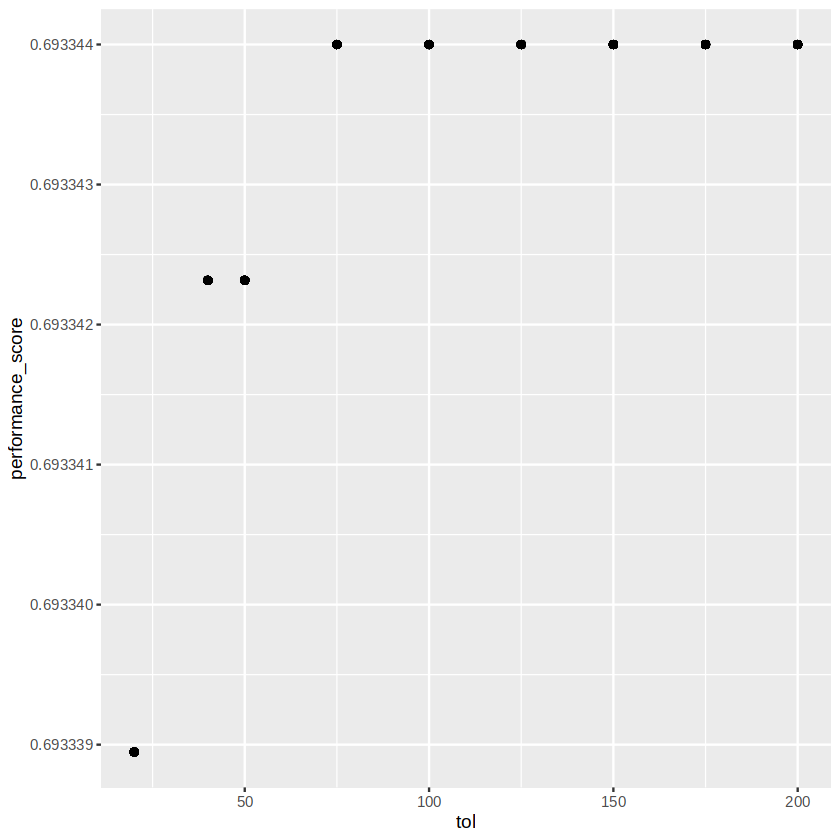

In [39]:
library(ggplot2)


# Create the volcano plot
ggplot(df3, aes(x = max_iter, y = performance_score)) +
 geom_point() +
  #scale_color_manual(values = c("black", "red")) +
  #theme_minimal() +
 #scale_x_log10()+ 
 scale_y_log10()+ 
  labs(x ="tol", y = "performance_score") 
  #theme(legend.position = "none") # Remove the legend if not needed

# If you want to add text labels to the significant points
#with(subset(df, Significant), text(FoldChange, LogPValue, labels = Gene, cex = 0.7, pos = 3))

# Note: Adjust the fold-change and p-value thresholds according to your dataset.


In [35]:
param_df1

In [13]:
# Define the files you want to keep
files_to_keep <- c("meta_table.tsv", "meta_table1.tsv", "Running_qiime2_in_R.ipynb", "qiime2_benchmark.ipynb", "otu_simpd.biom", "otu_table.txt", "otu_table.txt1", "otu_table1.biom", "sim_meta.tsv")

# List all files in the working directory
all_files <- list.files(path = "/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")

# Determine which files to delete
files_to_delete <- setdiff(all_files, files_to_keep)

# Delete the files
file.remove(files_to_delete)


Warning message in file.remove(files_to_delete):
“cannot remove file 'exported_ancompd', reason 'Directory not empty'”


[1]  TRUE FALSE  TRUE  TRUE

In [14]:
# Set the working directory
setwd("/home/zakir/from_pendrive/PhD/DAA_benchmark_study/qiime2_benchmark")

# List of files you want to keep
files_to_keep <- c("meta_table.tsv", "meta_table1.tsv", "Running_qiime2_in_R.ipynb",
                   "qiime2_benchmark.ipynb", "otu_simpd.biom", "otu_table.txt",
                   "otu_table.txt1", "otu_table1.biom", "sim_meta.tsv")

# Get all files in the directory
all_files <- list.files()

# Determine which files to delete
files_to_delete <- setdiff(all_files, files_to_keep)

# Delete the files
file_deletion_results <- sapply(files_to_delete, function(file){
  if(file.info(file)$isdir){
    # If it's a directory, use unlink with recursive=TRUE
    unlink(file, recursive = TRUE)
  } else {
    # If it's a file, use file.remove
    file.remove(file)
  }
})

# Check the results of file deletion
file_deletion_results


exported_ancompd 
               0

In [13]:
install.packages("pracma")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [14]:
library(pracma)

In [ ]:
# mlr library example clode - used in blog post: 
# https://towardsdatascience.com/decision-tree-hyperparameter-tuning-in-r-using-mlr-3248bfd2d88c

titanic <- read.csv('train.csv')

library(dplyr)
library(rpart)
library(rpart.plot)
library(Metrics)
library(mlr)
library(ggplot2)
library(plotly)

# Sample Fraud Data to speed up execution
set.seed(123)

# Subset Columns for Decision Tree
titanic <- titanic %>%
  select(Fare, Age, Sex, Pclass, Survived, SibSp, Parch)


# Splitting data into Train and Test
titanic['row_id'] = rownames(titanic)

set.seed(123)
train_data <- titanic %>%
  sample_frac(0.8)

test_data <- titanic %>%
  anti_join(train_data, by='row_id')

# Drop row_id from both dataframes
train_data[,'row_id'] <- NULL
test_data[,'row_id'] <- NULL

# Building our first decision tree
d.tree = rpart(Survived ~ ., 
               data=train_data, 
               method = 'class')

# Plotting our Tree
rpart.plot(d.tree, cex=0.55)

# Predict Values
predicted_values <- predict(d.tree, test_data, type = 'class')

# Getting Accuracy
accuracy(test_data$Survived, predicted_values)

# Building our d.tree with custom paremeters
d.tree.custom = rpart(Survived~ ., 
                      data=train_data, 
                      method = 'class',
                      control = c(maxdepth = 5, cp=0.001))

rpart.plot(d.tree.custom, cex=0.6)

# Predict test set data
predicted_values.custom <- predict(d.tree.custom, test_data, type = 'class')

# Accuracy of Custom D.Tree
accuracy(test_data$Survived, predicted_values.custom)

# Hyperparameter Tuning training with mlr
getParamSet("classif.rpart")

d.tree.mlr <- makeClassifTask(
  data=train_data, 
  target="Survived"
  )

# Search Parameter for Max Depth
param_grid <- makeParamSet( 
  makeDiscreteParam("maxdepth", values=1:30))

# Define Grid
control_grid = makeTuneControlGrid()

# Define Cross Validation
resample = makeResampleDesc("CV", iters = 3L)

# Define Measure
measure = acc


set.seed(123) 
dt_tuneparam <- tuneParams(learner='classif.rpart', 
                            task=d.tree.mlr, 
                            resampling = resample,
                            measures = measure,
                            par.set=param_grid, 
                            control=control_grid, 
                            show.info = TRUE)

# Extracting results
result_hyperparam <- generateHyperParsEffectData(dt_tuneparam, partial.dep = TRUE)

# Plotting Accuracy Score across different maxdepth
ggplot(
  data = result_hyperparam$data,
  aes(x = maxdepth, y=acc.test.mean)
) + geom_line(color = 'darkblue')

dt_tuneparam

# Pick Up Best Params and train them
best_parameters = setHyperPars(
  makeLearner("classif.rpart", predict.type = "prob"), 
  par.vals = dt_tuneparam$x
  )

best_model = train(best_parameters, d.tree.mlr)

d.tree.mlr.test <- makeClassifTask(
  data=test_data, 
  target="Survived"
)

# Predicting the best Model
results <- predict(best_model, task = d.tree.mlr.test)$data

accuracy(results$truth, results$response)

# Tweaking multiple hyperparameters
param_grid_multi <- makeParamSet( 
  makeDiscreteParam("maxdepth", values=1:30),
  makeNumericParam("cp", lower = 0.001, upper = 0.01),
  makeDiscreteParam("minsplit", values=1:10)
  )

dt_tuneparam_multi <- tuneParams(learner='classif.rpart', 
                           task=d.tree.mlr, 
                           resampling = resample,
                           measures = measure,
                           par.set=param_grid_multi, 
                           control=control_grid, 
                           show.info = TRUE)


# Extracting best Parameters from Multi Search
best_parameters_multi = setHyperPars(
  makeLearner("classif.rpart", predict.type = "prob"), 
  par.vals = dt_tuneparam_multi$x
)

best_model_multi = train(best_parameters_multi, d.tree.mlr)

# Predicting the best Model
results <- predict(best_model_multi, task = d.tree.mlr.test)$data

accuracy(results$truth, results$response)

# Extracting results from multigrid
result_hyperparam.multi <- generateHyperParsEffectData(dt_tuneparam_multi, partial.dep = TRUE)

# Sampling just for visualization
result_sample <- result_hyperparam.multi$data %>%
  sample_n(300)


hyperparam.plot <- plot_ly(result_sample, 
               x = ~cp, 
               y = ~maxdepth, 
               z = ~minsplit,
               marker = list(color = ~acc.test.mean,  colorscale = list(c(0, 1), c("darkred", "darkgreen")), showscale = TRUE))
hyperparam.plot <- hyperparam.plot %>% add_markers()
hyperparam.plot

In [ ]:
# caret library example used in blogpost:
# https://towardsdatascience.com/a-guide-to-using-caret-in-r-71dec0bda208

library(caTools)
library(caret)

# Train Test Split on both Iris and Mtcars

train_test_split <- function(df) {
  set.seed(42)
  sample = sample.split(df, SplitRatio = 0.8)
  train = subset(df, sample == TRUE)
  test  = subset(df, sample == FALSE)
  return (list(train, test))
}

# To Simplify, we are going to make iris a two classifiction
# problem

iris$target <- ifelse(
  iris$Species == 'setosa',
  1,
  0
)

# mtcars
mtcars_train <- train_test_split(mtcars)[[1]]
mtcars_test <- train_test_split(mtcars)[[2]]

# iris
iris_train <- train_test_split(iris)[[1]]
iris_test <- train_test_split(iris)[[2]]

# Training a Linear Model

lm_model <- train(mpg ~ hp + wt + gear + disp, 
      data = mtcars_train, 
      method = "lm")

summary(lm_model)

# Training a Logistic Regression

glm_model <- train(target ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
                  data = iris_train, 
                  method = "glm",
                  family = "binomial")

summary(glm_model)

# Training a decision tree
d.tree <- train(mpg ~ hp + wt + gear + disp, 
                  data = mtcars_train, 
                  method = "rpart")

library(rpart.plot)
rpart.plot(d.tree$finalModel)

# Examining our dtree
d.tree

# Training a Random Forest
r.forest <- train(mpg ~ hp + wt + gear + disp, 
                  data = mtcars_train, 
                  method = "ranger")

r.forest

# Training a XGBoost Model
xg.boost <- train(mpg ~ hp + wt + gear + disp, 
                  data = mtcars_train, 
                  method = "xgbTree")


# Training a k-nearest neighbor
knn <- train(mpg ~ hp + wt + gear + disp, 
                  data = mtcars_train, 
                  method = "knn")

# Training a neural network
neural.network <- train(mpg ~ hp + wt + gear + disp, 
             data = mtcars_train, 
             method = "neuralnet")

# Training a neural network for Classification
neural.network.class <- train(target ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
                        data = iris_train, 
                        method = "nnet")

# Results of Neural Network Class
neural.network.class

iris_train$target = factor(iris_train$target)

# Training a neural network for Classifiction with Factor
neural.network.class.2 <- train(target ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width, 
                              data = iris_train, 
                              method = "nnet")

# K-Fold Cross Validation

ctrl<- trainControl(method="cv", number=10)

d.tree.kfold <- train(mpg ~ hp + wt + gear + disp, 
                data = mtcars_train,
                trControl = ctrl,
                method = "rpart")
d.tree.kfold

rpart.plot(d.tree.kfold$finalModel)

# Optimizing for Another Metric
d.tree.kfold.rsquared <- train(mpg ~ hp + wt + gear + disp, 
                      data = mtcars_train,
                      trControl = ctrl,
                      metric = "Rsquared",
                      method = "rpart")

d.tree.kfold.rsquared


# Hyperparameter Tuning
d.tree.hyperparam <- train(mpg ~ hp + wt + gear + disp, 
                               data = mtcars_train,
                               trControl = ctrl,
                               metric = "Rsquared",
                               method = "rpart",
                               tuneGrid = data.frame(
                                 cp = c(0.0001, 0.001, 0.35, 0.65)))

d.tree.hyperparam


r.forest.hyperparam <- train(mpg ~ hp + wt + gear + disp, 
                           data = mtcars_train,
                           trControl = ctrl,
                           metric = "Rsquared",
                           method = "ranger",
                           tuneGrid = data.frame(
                             mtry = c(2, 3, 4),
                             min.node.size = c(2, 4, 10),
                             splitrule = c('variance')))

r.forest.hyperparam

# Predicting On the Test Set

# Linear Regression
predict(lm_model, mtcars_test)

# Decision Tree 
predict(d.tree, mtcars_test)

# Random Forest
predict(r.forest, mtcars_test)

# XGBoost
predict(xg.boost, mtcars_test)

# Comparing Predictions

predictions <- data.frame(
  rf = predict(r.forest, mtcars_test),
  xgboost = predict(xg.boost, mtcars_test)
)

library(ggplot2)

ggplot(
  data = predictions,
  aes(x = rf, y = xgboost)
) + geom_point()